C:\Users\xiaoy\AppData\Local\Temp\ipykernel_31088\1399542332.py:58: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_age_ord = linkage(dist_matrix_age_ord, method='complete')


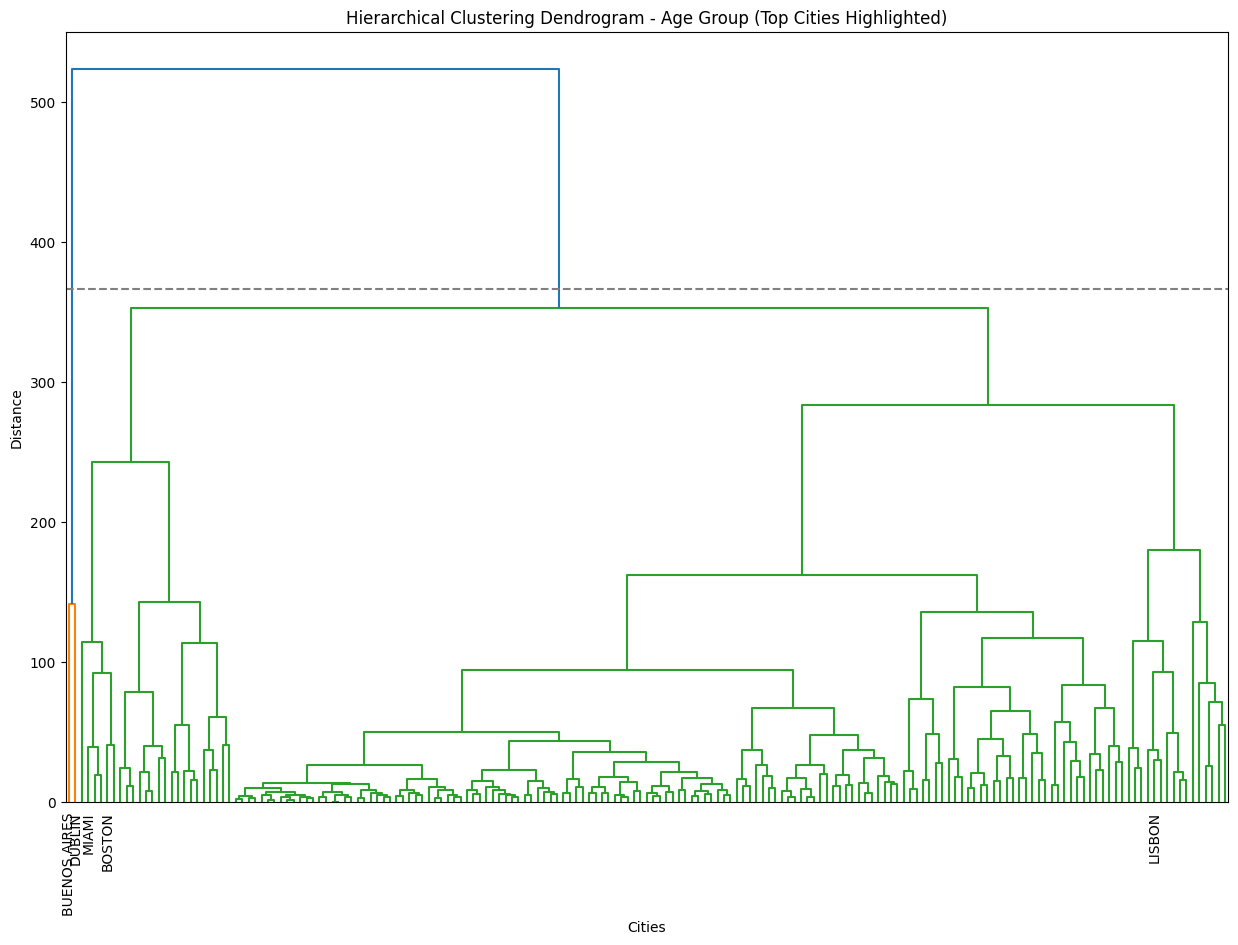

(['DUBLIN', 'BUENOS AIRES'], ['LISBON', 'MIAMI', 'BOSTON'])

In [1]:
# Re-importing necessary libraries and redefining functions
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from matplotlib import pyplot as plt

# Re-load the dataset
file_path = 'Desktop/translated_ZZ22.csv'
df = pd.read_csv(file_path, encoding='ISO-8859-1')

# Creating a long format dataframe
df_long = df.loc[df.index.repeat(df['NUMBER_OF_VOTERS_PROFILE'])]

# Creating a wide format dataframe for Age Group
df_wide_age = df_long.pivot_table(index='CITY_NAME', columns='AGE_GROUP_CODE', values='NUMBER_OF_VOTERS_PROFILE', aggfunc='size', fill_value=0)
df_wide_age['Total'] = df_wide_age.sum(axis=1)

# Custom ordered distance function for age data
def dev_multinom(x, y):
    # Kullback-Leibler divergence
    return 2 * np.sum(np.where((x == 0) | (y == 0), 0, x * np.log(x / y)))

def l2_dist(x, y):
    # L2 (Euclidean) distance
    return np.sum((x - y) ** 2)

def cat_dist(x, y, deviance=False, normalize=False):
    wx = np.sum(x)
    wy = np.sum(y)
    m = (x + y) / (wx + wy) # center
    x = x / wx
    y = y / wy
    D = dev_multinom if deviance else l2_dist
    if normalize:
        return np.sqrt(.5 * wx / (wx + wy) * D(x, m)) + np.sqrt(.5 * wy / (wx + wy) * D(y, m))
    else:
        return np.sqrt(.5 * wx * D(x, m)) + np.sqrt(.5 * wy * D(y, m))

def ord_dist(x, y, normalize=False):
    wx = np.sum(x)
    wy = np.sum(y)
    k = len(x) # should be equal to len(y)
    x = np.cumsum(x)[:-1]
    y = np.cumsum(y)[:-1]
    m = (x + y) / (wx + wy) # center
    x = x / wx
    y = y / wy
    if normalize:
        return np.sqrt(wx / (wx + wy) * l2_dist(x, m)) + np.sqrt(wy / (wx + wy) * l2_dist(y, m))
    else:
        return np.sqrt(wx * l2_dist(x, m)) + np.sqrt(wy * l2_dist(y, m))

# Creating a distance matrix for the age group dataframe using ordered distance
dist_matrix_age_ord = squareform(pdist(df_wide_age.drop('Total', axis=1), metric=ord_dist))

# Performing hierarchical clustering
Z_age_ord = linkage(dist_matrix_age_ord, method='complete')

# Identifying the two main clusters
max_d = max(Z_age_ord[:, 2]) * 0.7  # A heuristic to find the distance threshold for the main bifurcation
clusters = fcluster(Z_age_ord, max_d, criterion='distance')

# Adding cluster labels to the dataframe
df_wide_age['Cluster'] = clusters
df_wide_ms = df_long.pivot_table(index='CITY_NAME', columns='MARITAL_STATUS_CODE', values='NUMBER_OF_VOTERS_PROFILE', aggfunc='size', fill_value=0)
df_wide_gender = df_long.pivot_table(index='CITY_NAME', columns='GENDER_CODE', values='NUMBER_OF_VOTERS_PROFILE', aggfunc='size', fill_value=0)
df_wide_education = df_long.pivot_table(index='CITY_NAME', columns='EDUCATION_LEVEL_CODE', values='NUMBER_OF_VOTERS_PROFILE', aggfunc='size', fill_value=0)

# Separating the data into two main clusters
cluster1 = df_wide_age[df_wide_age['Cluster'] == 1]
cluster2 = df_wide_age[df_wide_age['Cluster'] == 2]

# Identifying the top three cities in each cluster by total population
top3_cluster1 = cluster1.nlargest(3, 'Total').index.tolist()
top3_cluster2 = cluster2.nlargest(3, 'Total').index.tolist()

# Combining top cities from both clusters
top_cities = top3_cluster1 + top3_cluster2

# Plotting the dendrogram with only top cities labeled
plt.figure(figsize=(15, 10))
dendrogram(Z_age_ord, labels=df_wide_age.index, leaf_rotation=90, leaf_font_size=10, color_threshold=max_d)

# Modifying the labels to only show the top cities
for label in plt.gca().get_xmajorticklabels():
    if label.get_text() not in top_cities:
        label.set_visible(False)

plt.title("Hierarchical Clustering Dendrogram - Age Group (Top Cities Highlighted)")
plt.xlabel('Cities')
plt.ylabel('Distance')
plt.axhline(y=max_d, color='gray', linestyle='dashed')  # Threshold line for two main clusters
plt.show()

top3_cluster1, top3_cluster2

